# Annotate the differential abundance results

Author: Minghang Li

## 1. Set up

As always, we'll start by loading the necessary Python modules and reading in the data.

In [3]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from pathlib import Path
import requests
from matplotlib.patches import Patch
import xml.etree.ElementTree as ET
from typing import List, Dict, Tuple
import time
from Bio.KEGG import REST


%matplotlib inline

In [4]:
# set pd column width to display full text
pd.set_option('display.max_colwidth', 150)

In [5]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = Path(root[0])

# assigning variables throughout the notebook
raw_data_dir = root / "data" / "raw"
data_dir = root / "data" / "processed"
vis_dir  = root / "results"

In [52]:
# import shared functions from the utils script and the secret file for passwords

import sys
sys.path.append(root.as_posix())

from secret import BIOCYC_PW, BIOCYC_USER
import utils

## KEGG

In [24]:
ko_vis_dir = vis_dir / "ko_metagenome_downstream_analysis"

In [79]:
lfc_ko = pd.read_csv(ko_vis_dir / "significant_pathways_by_cohort.csv")
lfc_ko.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,K00030,-2.254679,0.036895
1,K00042,-1.641490,0.012549
2,K00076,-2.008130,0.025288
3,K00087,-1.806933,0.020815
4,K00108,1.880564,0.012559


In [152]:
se_ko = pd.read_csv(
    data_dir
    / "ko_metagenome_downstream_analysis"
    / "ancombc_differentials_cohort"
    / "se_slice.csv"
)
se_ko = se_ko.drop(columns=["(Intercept)"])
se_ko = se_ko.rename(columns={"id": "metagene", "cohortAfter abduction": "se"})
se_ko.head()

,metagene,se
0,K00001,0.373263
1,K00003,0.334746
2,K00004,0.436775
3,K00005,0.304835
4,K00007,0.421504


In [174]:
lfc_ko_with_se = pd.merge(lfc_ko, se_ko, on="metagene", how="left")
lfc_ko_with_se.head()

,metagene,log2foldchange_After abduction,q-value_After abduction,se
0,K00030,-2.254679,0.036895,0.501846
1,K00042,-1.641490,0.012549,0.347832
2,K00076,-2.008130,0.025288,0.439088
3,K00087,-1.806933,0.020815,0.391599
4,K00108,1.880564,0.012559,0.398508


In [181]:
lfc_ko_with_se = lfc_ko_with_se.sort_values(
    "log2foldchange_After abduction", ascending=True
)

In [223]:
def get_ko_info(ko_number: str) -> str:
    """
    Retrieve information for a KEGG Orthology (KO) number

    Args:
        ko_number (str): KO number (e.g., 'K00030')

    Returns:
        str: KO name
    """
    kegg_url = f"http://rest.kegg.jp/find/ko/{ko_number}"
    while True:
        try:
            response = requests.get(kegg_url)
            break
        except requests.exceptions.ConnectionError:
            time.sleep(5)
            continue
    if response.status_code != 200:
        return None, None
    *_, name = response.text.split("\t")[1].split(";")
    name = name.strip()
    return name

In [229]:
lfc_ko_with_se["name"] = lfc_ko_with_se["metagene"].apply(get_ko_info)

In [50]:
lfc_ko_with_se.head(20)

,metagene,log2foldchange_After abduction,q-value_After abduction,se,name
0,K00689,-3.296469,0.000148,0.593244,dextransucrase [EC:2.4.1.5]
1,K07650,-3.042066,0.000030,0.521689,"two-component system, OmpR family, sensor histidine kinase CssS [EC:2.7.13.3]"
2,K06859,-2.929887,0.000566,0.551036,"glucose-6-phosphate isomerase, archaeal [EC:5.3.1.9]"
3,K09116,-2.818665,0.006515,0.580972,"damage-control phosphatase, subfamily I [EC:3.1.3.-]"
4,K09696,-2.790146,0.000030,0.478673,sodium transport system permease protein
5,K09697,-2.771799,0.000036,0.478026,sodium transport system ATP-binding protein [EC:7.2.2.4]
6,K03390,-2.724815,0.000998,0.522741,heterodisulfide reductase subunit C2 [EC:1.8.7.3 1.8.98.4 1.8.98.5 1.8.98.6]
7,K07770,-2.720148,0.000270,0.499039,"two-component system, OmpR family, response regulator CssR"
8,K06408,-2.718368,0.000196,0.493592,stage V sporulation protein AF
9,K00952,-2.689326,0.028147,0.590981,nicotinamide-nucleotide adenylyltransferase [EC:2.7.7.1]


In [51]:
lfc_ko_with_se.tail(20)

,metagene,log2foldchange_After abduction,q-value_After abduction,se,name
159,K03893,1.947133,0.025053,0.425565,arsenical pump membrane protein
160,K16013,1.947422,0.007502,0.403734,"ATP-binding cassette, subfamily C, bacterial CydD"
161,K02002,1.952042,0.004673,0.396969,glycine betaine/proline transport system substrate-binding protein
162,K03293,1.960362,0.029153,0.431507,"amino acid transporter, AAT family"
163,K05520,1.965094,0.009596,0.411631,deglycase [EC:3.5.1.124]
164,K01669,1.997304,0.003335,0.400799,deoxyribodipyrimidine photo-lyase [EC:4.1.99.3]
165,K01419,2.000987,0.029595,0.440765,"ATP-dependent HslUV protease, peptidase subunit HslV [EC:3.4.25.2]"
166,K03667,2.016690,0.026130,0.441630,ATP-dependent HslUV protease ATP-binding subunit HslU
167,K05845,2.017472,0.002087,0.397636,osmoprotectant transport system substrate-binding protein
168,K03638,2.018353,0.025599,0.441575,molybdopterin adenylyltransferase [EC:2.7.7.75]


In [230]:
lfc_ko_with_se.to_csv(ko_vis_dir / "significant_ko_by_cohort_annotated.csv", index=False)

In [25]:
lfc_ko_with_se = pd.read_csv(ko_vis_dir / "significant_ko_by_cohort_annotated.csv")

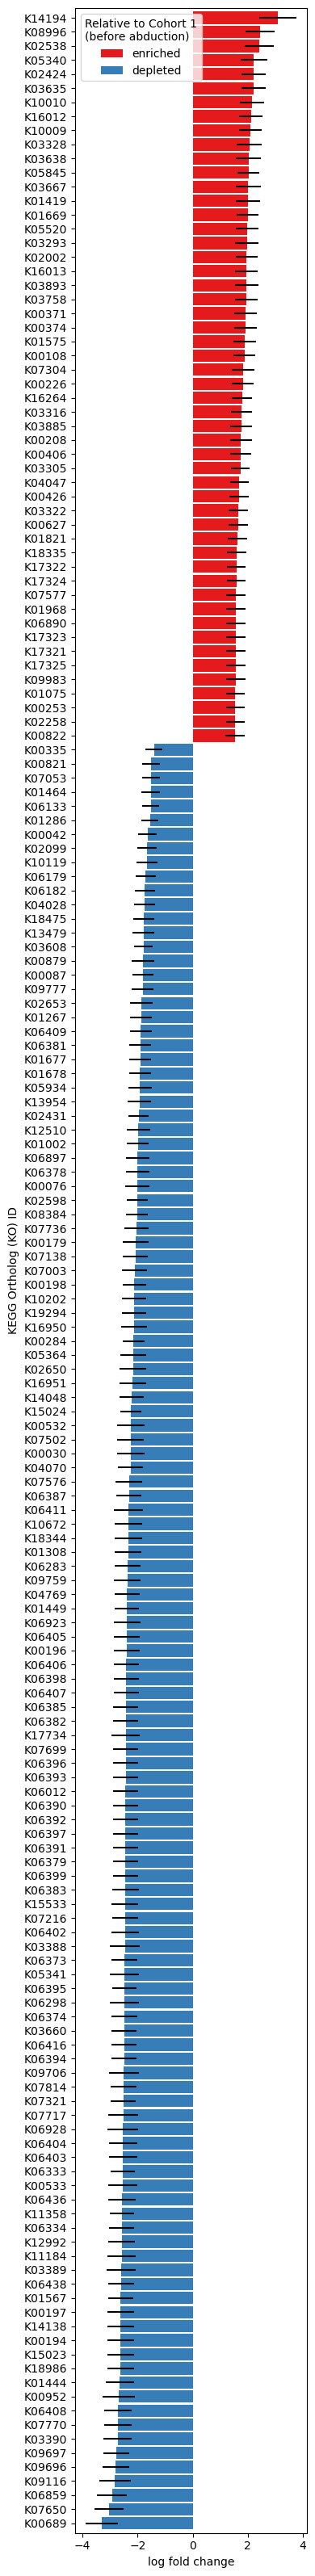

In [27]:
# plot the log2foldchange of enzymes as a bar plot
barh_styles = {"width": 0.88}

palette = sns.color_palette("Set1", 2)
colors = [
    palette[0] if x > 0 else palette[1]
    for x in lfc_ko_with_se["log2foldchange_After abduction"]
]

ax = lfc_ko_with_se.plot.barh(
    x="metagene",
    y="log2foldchange_After abduction",
    xerr="se",
    figsize=(4, 32),
    color=colors,
    **barh_styles
)

ax.set_ylabel("KEGG Ortholog (KO) ID")
ax.set_xlabel("log fold change")

legend_elements = [
    Patch(facecolor=palette[0], label="enriched"),
    Patch(facecolor=palette[1], label="depleted"),
]
ax.legend(handles=legend_elements, loc="upper left", title="Relative to Cohort 1\n(before abduction)")
# tight layout
plt.tight_layout()
ax.get_figure().savefig(ko_vis_dir / "ko_da_barplot.png", dpi=300)

## EC

In [31]:
ec_vis_dir = vis_dir / "ec_metagenome_downstream_analysis"

Download EXPASY enzyme database as a reference for EC numbers.

In [4]:
! wget -O $data_dir/ec_metagenome_downstream_analysis/enzyme.dat https://ftp.expasy.org/databases/enzyme/enzyme.dat

--2024-12-21 16:19:29--  https://ftp.expasy.org/databases/enzyme/enzyme.dat
Resolving ftp.expasy.org (ftp.expasy.org)... 192.33.215.162
Connecting to ftp.expasy.org (ftp.expasy.org)|192.33.215.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9428206 (9.0M) [text/plain]
Saving to: ‘/home/matchy233/study/alien/data/processed/ec_metagenome_downstream_analysis/enzyme.dat’

/home/matchy233/stu 100%[===================>]   8.99M  31.6MB/s    in 0.3s    

2024-12-21 16:19:29 (31.6 MB/s) - ‘/home/matchy233/study/alien/data/processed/ec_metagenome_downstream_analysis/enzyme.dat’ saved [9428206/9428206]



Read previous results (from `07_b_downstream_analysis/02_ec_analysis.ipynb`) 

In [32]:
lfc_ec = pd.read_csv(ec_vis_dir / "significant_enzymes_by_cohort.csv")
lfc_ec.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,EC:1.1.1.103,-1.687152,0.040528
1,EC:1.1.1.14,-1.845816,0.000927
2,EC:1.1.1.159,-2.563178,0.000004
3,EC:1.1.1.261,-2.384744,0.000262
4,EC:1.1.1.267,-1.575203,0.000110


In [33]:
# define top level enzyme classes
enzyme_mapping_level1 = {
    "EC:1": "Oxidoreductases",
    "EC:2": "Transferases",
    "EC:3": "Hydrolases",
    "EC:4": "Lyases",
    "EC:5": "Isomerases",
    "EC:6": "Ligases",
    "EC:7": "Translocases",
}


In [34]:
# use the mapping to get the level 1 enzyme class
lfc_ec["enzyme_class"] = lfc_ec.loc[:,"metagene"].apply(
    lambda x: enzyme_mapping_level1[x.split(".")[0]]
)


In [35]:
lfc_ec["enzyme_class"].value_counts()

enzyme_class
Transferases       46
Oxidoreductases    42
Hydrolases         26
Lyases             14
Isomerases         14
Ligases            10
Name: count, dtype: int64

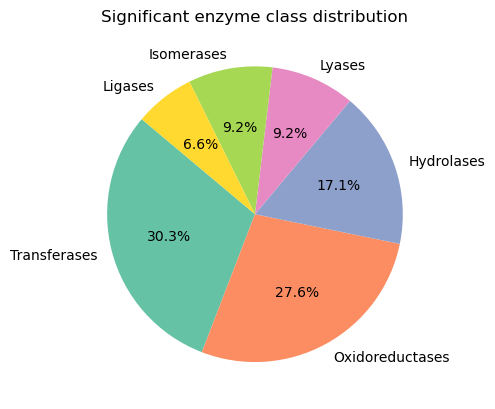

In [36]:
# plot enzyme class distribution as a pie chart
ax = lfc_ec["enzyme_class"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, colors=sns.color_palette("Set2")
)
ax.set_ylabel("")
ax.set_title("Significant enzyme class distribution")

plt.savefig(ec_vis_dir / "significant_enzyme_class_pie_chart.png", dpi=300)

In [37]:
# import biopython ExPASy module
from Bio.ExPASy import Enzyme
handle = open(data_dir / "ec_metagenome_downstream_analysis" / "enzyme.dat")
records = Enzyme.parse(handle)
enzyme_mapping = {
    record["ID"]: record["DE"].rstrip(".") for record in records
}

In [38]:
# sort lfc_qval_significant by lfc
lfc_ec["enzyme"] = lfc_ec["metagene"].apply(
    lambda x: enzyme_mapping.get(x.split(":")[1], "Unknown")
)
lfc_ec = lfc_ec.sort_values(by="log2foldchange_After abduction", ascending=True)

# show depleted enzymes that are < 5% compared to before abduction
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3][["metagene", "enzyme_class", "enzyme"]]


,metagene,enzyme_class,enzyme
61,EC:2.4.1.5,Transferases,dextransucrase
51,EC:2.1.1.245,Transferases,5-methyltetrahydrosarcinapterin:corrinoid/iron-sulfur proteinCo-methyltransferase
100,EC:3.5.1.26,Hydrolases,N(4)-(beta-N-acetylglucosaminyl)-L-asparaginase
54,EC:2.1.1.258,Transferases,5-methyltetrahydrofolate:corrinoid/iron-sulfur proteinCo-methyltransferase
56,EC:2.3.1.169,Transferases,CO-methylating acetyl-CoA synthase
40,EC:1.8.98.1,Oxidoreductases,dihydromethanophenazine:CoB--CoM heterodisulfide reductase
60,EC:2.4.1.4,Transferases,amylosucrase
58,EC:2.4.1.211,Transferases,"1,3-beta-galactosyl-N-acetylhexosamine phosphorylase"
110,EC:3.6.1.15,Hydrolases,nucleoside-triphosphate phosphatase


In [39]:
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3]["enzyme_class"].value_counts()

enzyme_class
Transferases       6
Hydrolases         2
Oxidoreductases    1
Name: count, dtype: int64

<Axes: ylabel='count'>

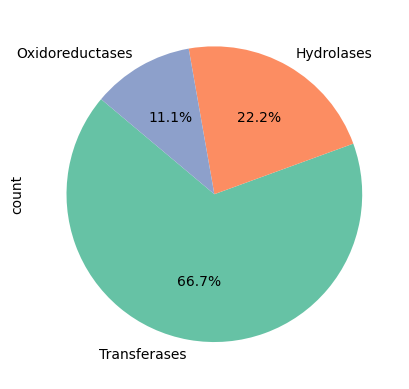

In [40]:
lfc_ec[lfc_ec["log2foldchange_After abduction"] < -3]["enzyme_class"].value_counts().plot.pie(
    autopct="%1.1f%%", startangle=140, colors=sns.color_palette("Set2")
)

In [41]:
lfc_ec[lfc_ec["log2foldchange_After abduction"] < 0].shape[0]

152

In [42]:
se_ec = pd.read_csv(
    data_dir
    / "ec_metagenome_downstream_analysis"
    / "ancombc_differentials_cohort"
    / "se_slice.csv"
)
se_ec = se_ec.drop(columns=["(Intercept)"])
se_ec = se_ec.rename(columns={"id": "metagene", "cohortAfter abduction": "se"})
se_ec.head()

,metagene,se
0,EC:1.1.1.1,0.239708
1,EC:1.1.1.100,0.254684
2,EC:1.1.1.103,0.400387
3,EC:1.1.1.108,0.553945
4,EC:1.1.1.11,0.452219


In [43]:
lfc_ec_with_se = lfc_ec.merge(se_ec, on="metagene", how="left")
assert len(lfc_ec) == len(lfc_ec_with_se)

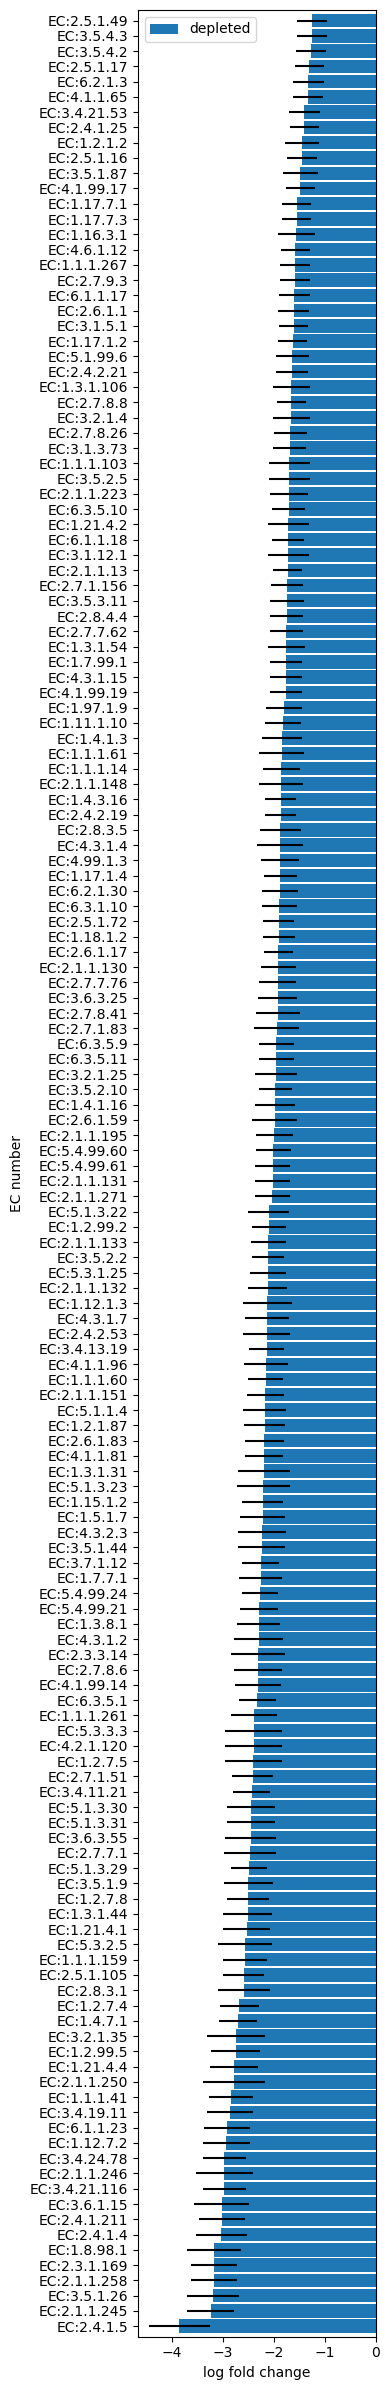

In [44]:
# plot the log2foldchange of enzymes as a bar plot
ax = lfc_ec_with_se.plot.barh(
    y="log2foldchange_After abduction",
    x="metagene",
    figsize=(4, 24),
    width=0.88,
    xerr="se",
    label="depleted"
)

ax.set_ylabel("EC number")
ax.set_xlabel("log fold change")
ax.legend(loc="upper left")
plt.tight_layout()

ax.get_figure().savefig(ec_vis_dir / "ec_da_barplot.png", dpi=300)

In [36]:
lfc_ec.to_csv(ec_vis_dir / "significant_enzymes_by_cohort_annotated.csv", index=False)

### MetaCyc pathways

In [8]:
pathabun_vis_dir = vis_dir / "pathway_abundance_downstream_analysis"

### By Cohort

In [9]:
lfc_metacyc = pd.read_csv(pathabun_vis_dir / "significant_pathways_by_cohort.csv")
lfc_metacyc.head()

,metagene,log2foldchange_After abduction,q-value_After abduction
0,ARG+POLYAMINE-SYN,-1.127526,0.003732
1,ASPASN-PWY,-1.230605,0.000123
2,CENTFERM-PWY,-1.625897,0.000388
3,COBALSYN-PWY,-1.637630,0.000092
4,DAPLYSINESYN-PWY,-1.094884,0.000129


In [10]:
def get_pathway_name_from_biocyc(session: requests.Session, pathway_id: str):
    URL = f"https://websvc.biocyc.org/getxml?id=META:{pathway_id}"
    response = session.get(URL)
    if response.status_code != 200:
        return "Unknown"
    root = ET.fromstring(response.text)
    pathway_name = root.find(".//Pathway/common-name").text
    return pathway_name

In [47]:
# connect to BioCyc
s = requests.Session()  # create session
# Post login credentials to session:
r = s.post(
    "https://websvc.biocyc.org/credentials/login/",
    data={"email": BIOCYC_USER, "password": BIOCYC_PW},
)

# Check if login was successful
r.status_code


200

In [12]:
os.listdir(pathabun_vis_dir)

['jaccard_pcoa_Patient_Sex.png',
 'bray_curtis_pcoa_Stool_Consistency.png',
 'significant_pathways_by_cohort.csv',
 'jaccard_cohort_beta-group-significance.png',
 'jaccard_pcoa_Stool_Consistency.png',
 'jaccard_pcoa_Cohort_Number.png',
 'significant_pathways_by_cohort_annotated.csv',
 'bray_curtis_pcoa_Cohort_Number.png',
 'significant_pathways_by_stool_consistency_liquid.csv',
 'bray_curtis_cohort_beta-group-significance.png',
 'bray_curtis_pcoa_Patient_Sex.png']

In [13]:

if "significant_pathways_by_cohort_annotated.csv" in os.listdir(pathabun_vis_dir):
    lfc_metacyc = pd.read_csv(pathabun_vis_dir / "significant_pathways_by_cohort_annotated.csv")
else:
    lfc_metacyc["pathway_name"] = lfc_metacyc["metagene"].apply(
        lambda x: get_pathway_name_from_biocyc(s, x)
    )
# if we have pathabun_vis_dir / "significant_pathways_by_cohort_annotated.csv", we can load it
lfc_metacyc.head()

,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
0,METH-ACETATE-PWY,-3.053729,1.004840e-08,methanogenesis from acetate
1,PWY-7332,-2.889324,2.581338e-03,superpathway of UDP-N-acetylglucosamine-derived O-antigen building blocks biosynthesis
2,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05,NAD salvage pathway III (to nicotinamide riboside)
3,FUCCAT-PWY,-2.422689,1.664643e-09,L-fucose degradation I
4,PWY-7198,-2.396626,1.639304e-03,pyrimidine deoxyribonucleotides de novo biosynthesis IV


In [14]:
# remove <i> tags from pathway names
lfc_metacyc["pathway_name"] = (
    lfc_metacyc["pathway_name"].str.replace("<i>", "").str.replace("</i>", "").str.replace("<I>", "").str.replace("</I>", "")
)
lfc_metacyc = lfc_metacyc.sort_values(
    by="log2foldchange_After abduction", ascending=True
)
lfc_metacyc.head(20)

,metagene,log2foldchange_After abduction,q-value_After abduction,pathway_name
0,METH-ACETATE-PWY,-3.053729,1.004840e-08,methanogenesis from acetate
1,PWY-7332,-2.889324,2.581338e-03,superpathway of UDP-N-acetylglucosamine-derived O-antigen building blocks biosynthesis
2,NAD-BIOSYNTHESIS-II,-2.519755,2.837803e-05,NAD salvage pathway III (to nicotinamide riboside)
3,FUCCAT-PWY,-2.422689,1.664643e-09,L-fucose degradation I
4,PWY-7198,-2.396626,1.639304e-03,pyrimidine deoxyribonucleotides de novo biosynthesis IV
5,PWY-7210,-2.372636,2.498562e-03,pyrimidine deoxyribonucleotides biosynthesis from CTP
6,PWY-5676,-2.369860,3.555472e-02,acetyl-CoA fermentation to butanoate
7,P162-PWY,-2.325231,1.902229e-03,L-glutamate degradation V (via hydroxyglutarate)
8,PWY-5705,-2.304107,4.970931e-07,allantoin degradation to glyoxylate III
9,PWY-5677,-2.296525,4.348278e-04,succinate fermentation to butanoate


In [99]:
lfc_metacyc.to_csv(pathabun_vis_dir / "significant_pathways_by_cohort_annotated.csv", index=False)

In [15]:
BIOSYNTHESIS_PATHWAYS = lfc_metacyc["pathway_name"].str.contains("biosynthesis", case=False)
print(f"Number of biosynthesis pathways: {BIOSYNTHESIS_PATHWAYS.sum()}")

Number of biosynthesis pathways: 23


In [16]:
lfc_not_biosynthesis = lfc_metacyc[~BIOSYNTHESIS_PATHWAYS]
DEGRADATION_PATHWAYS = lfc_not_biosynthesis["pathway_name"].str.contains("degradation", case=False)
print(f"Number of degradation pathways: {lfc_not_biosynthesis[DEGRADATION_PATHWAYS].shape[0]}")

Number of degradation pathways: 17


In [17]:
not_syn_or_deg = lfc_not_biosynthesis[~DEGRADATION_PATHWAYS]
print(f"Number of other pathways: {not_syn_or_deg.shape[0]}")

Number of other pathways: 17


In [18]:
se_pathabun = pd.read_csv(
    data_dir
    / "pathway_abundance_downstream_analysis"
    / "ancombc_differentials_cohort"
    / "se_slice.csv"
)
se_pathabun = se_pathabun.drop(columns=["(Intercept)"])
se_pathabun = se_pathabun.rename(columns={"id": "metagene", "cohortAfter abduction": "se"})
se_pathabun.head()

,metagene,se
0,1CMET2-PWY,0.238187
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.525033
2,AEROBACTINSYN-PWY,0.532395
3,ALL-CHORISMATE-PWY,0.555946
4,ANAEROFRUCAT-PWY,0.250856


In [19]:
lfc_metacyc_with_se = lfc_metacyc.merge(se_pathabun, on="metagene", how="left")
assert len(lfc_metacyc) == len(lfc_metacyc_with_se)

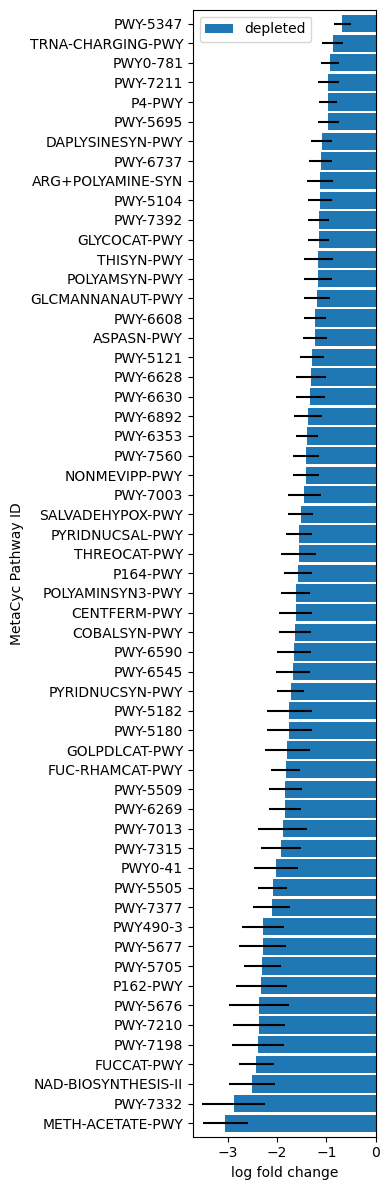

In [45]:
# plot the log2foldchange of enzymes as a bar plot
ax = lfc_metacyc_with_se.plot.barh(
    y="log2foldchange_After abduction",
    x="metagene",
    figsize=(4, 12),
    width=0.88,
    xerr="se",
    label="depleted"
)

ax.set_ylabel("MetaCyc Pathway ID")
ax.set_xlabel("log fold change")
ax.legend(loc="upper left")

plt.tight_layout()
ax.get_figure().savefig(pathabun_vis_dir / "pathabun_da_barplot.png", dpi=300)

### By Stool Consistency


In [90]:
lfc_metacyc_stool = pd.read_csv(pathabun_vis_dir / "significant_pathways_by_stool_consistency_liquid.csv")

In [91]:
lfc_metacyc_stool.head()

,metagene,log2foldchange_liquid,log2foldchange_semi-formed,q-value_liquid,q-value_semi-formed
0,PWY-5180,2.141376,0.631737,0.022271,1
1,PWY-5182,2.141376,0.631737,0.022271,1


In [97]:
lfc_metacyc_stool["pathway_name"] = lfc_metacyc_stool["metagene"].apply(
    lambda x: get_pathway_name_from_biocyc(s, x)
)
lfc_metacyc_stool["pathway_name"] = lfc_metacyc_stool["pathway_name"].str.replace("<I>", "").str.replace("</I>", "").str.replace("<i>", "").str.replace("</i>", "")
lfc_metacyc_stool.head()

,metagene,log2foldchange_liquid,log2foldchange_semi-formed,q-value_liquid,q-value_semi-formed,pathway_name
0,PWY-5180,2.141376,0.631737,0.022271,1,toluene degradation I (aerobic) (via o-cresol)
1,PWY-5182,2.141376,0.631737,0.022271,1,Unknown
